In [43]:
!pip install pandas numpy matplotlib seaborn scikit-learn jinja2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
AC_CAPACITY = 100.0  # MW
DC_CAPACITY = 130.0  # MW


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [44]:
def generate_solar_data(year=2024):    
    # Time Index
    dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31 23:00:00', freq='H')
    df = pd.DataFrame(index=dates)
    
    # Solar Geometry
    doy = df.index.dayofyear
    hod = df.index.hour
    
    # Seasonality (Peak Summer) & Daily Cycle (Bell Curve)
    seasonal_factor = 1 + 0.15 * np.cos(2 * np.pi * (doy - 172) / 365)
    daily_profile = np.maximum(0, np.cos(np.pi * (hod - 12) / 12)) ** 3
    
    # Weather Simulation (Clouds)
    np.random.seed(42) # Consistent seed for reproducibility
    cloud_cover = np.random.beta(a=8, b=2, size=len(df))
    true_ghi = 1000 * daily_profile * seasonal_factor * cloud_cover
    true_temp = 25 + (10 * np.cos(2 * np.pi * (doy - 172) / 365)) + (5 * np.cos(np.pi * (hod - 14) / 12))
    
    # Plant Performance (With Realistic Efficiency Fluctuations)
    # Dust/wiring causes random 0-5% loss invisible to sensors.
    efficiency_noise = np.random.uniform(0.95, 1.00, size=len(df))
    
    # Temp Loss Calculation
    cell_temp = true_temp + (true_ghi / 800) * 25
    temp_loss = 1 + (cell_temp - 25) * -0.0035
    
    # Calculate Power
    dc_gen = DC_CAPACITY * (true_ghi / 1000) * temp_loss * efficiency_noise
    df['DC_Power_MW'] = np.maximum(0, dc_gen)
    
    # Grid Injection (Clipping at 100MW)
    df['Active_Power_MW'] = np.minimum(df['DC_Power_MW'], AC_CAPACITY)
    
    # Sensor Readings (Input Data for Model)
    df['Irradiance_Wm2'] = np.maximum(0, true_ghi + np.random.normal(0, 15, size=len(df)))
    df['Module_Temp_C'] = cell_temp + np.random.normal(0, 1, size=len(df))
    
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    
    return df

df = generate_solar_data()
print(f"Dataset Ready: {len(df)} hourly records.")
print(f"Total Annual Generation: {df['Active_Power_MW'].sum():,.2f} MWh")

Dataset Ready: 8784 hourly records.
Total Annual Generation: 173,108.47 MWh


/tmp/ipykernel_32424/3589318733.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31 23:00:00', freq='H')


/tmp/ipykernel_32424/1269979706.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_gen.index, y=monthly_gen.values, ax=ax[0], palette="viridis")


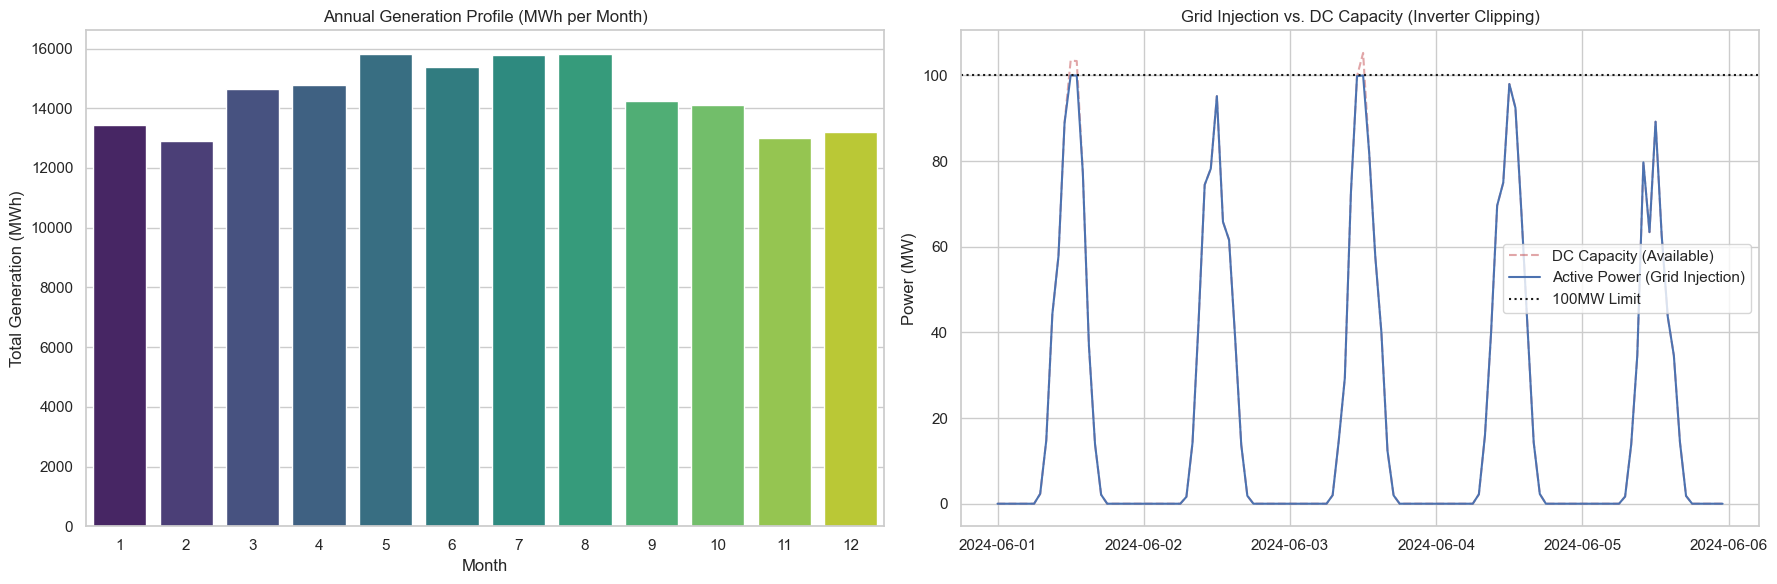

In [45]:
# Create Subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Annual Seasonality
monthly_gen = df.groupby('Month')['Active_Power_MW'].sum()
sns.barplot(x=monthly_gen.index, y=monthly_gen.values, ax=ax[0], palette="viridis")
ax[0].set_title("Annual Generation Profile (MWh per Month)")
ax[0].set_ylabel("Total Generation (MWh)")
ax[0].set_xlabel("Month")

# PInverter Clipping (Zoom-in on June)
summer_slice = df[(df.index.month == 6) & (df.index.day <= 5)]
ax[1].plot(summer_slice.index, summer_slice['DC_Power_MW'], 'r--', label='DC Capacity (Available)', alpha=0.5)
ax[1].plot(summer_slice.index, summer_slice['Active_Power_MW'], 'b-', label='Active Power (Grid Injection)')
ax[1].axhline(100, color='k', linestyle=':', label='100MW Limit')
ax[1].set_title("Grid Injection vs. DC Capacity (Inverter Clipping)")
ax[1].set_ylabel("Power (MW)")
ax[1].legend()

plt.tight_layout()
plt.show()

In [46]:

# Select Features (Inputs) and Target (Output)
features = ['Irradiance_Wm2', 'Module_Temp_C', 'Month', 'Hour']
target = 'Active_Power_MW'

X = df[features]
y = df[target]

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest (The Champion Model)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f} MW")

R² Score: 0.9985
Mean Absolute Error: 0.58 MW


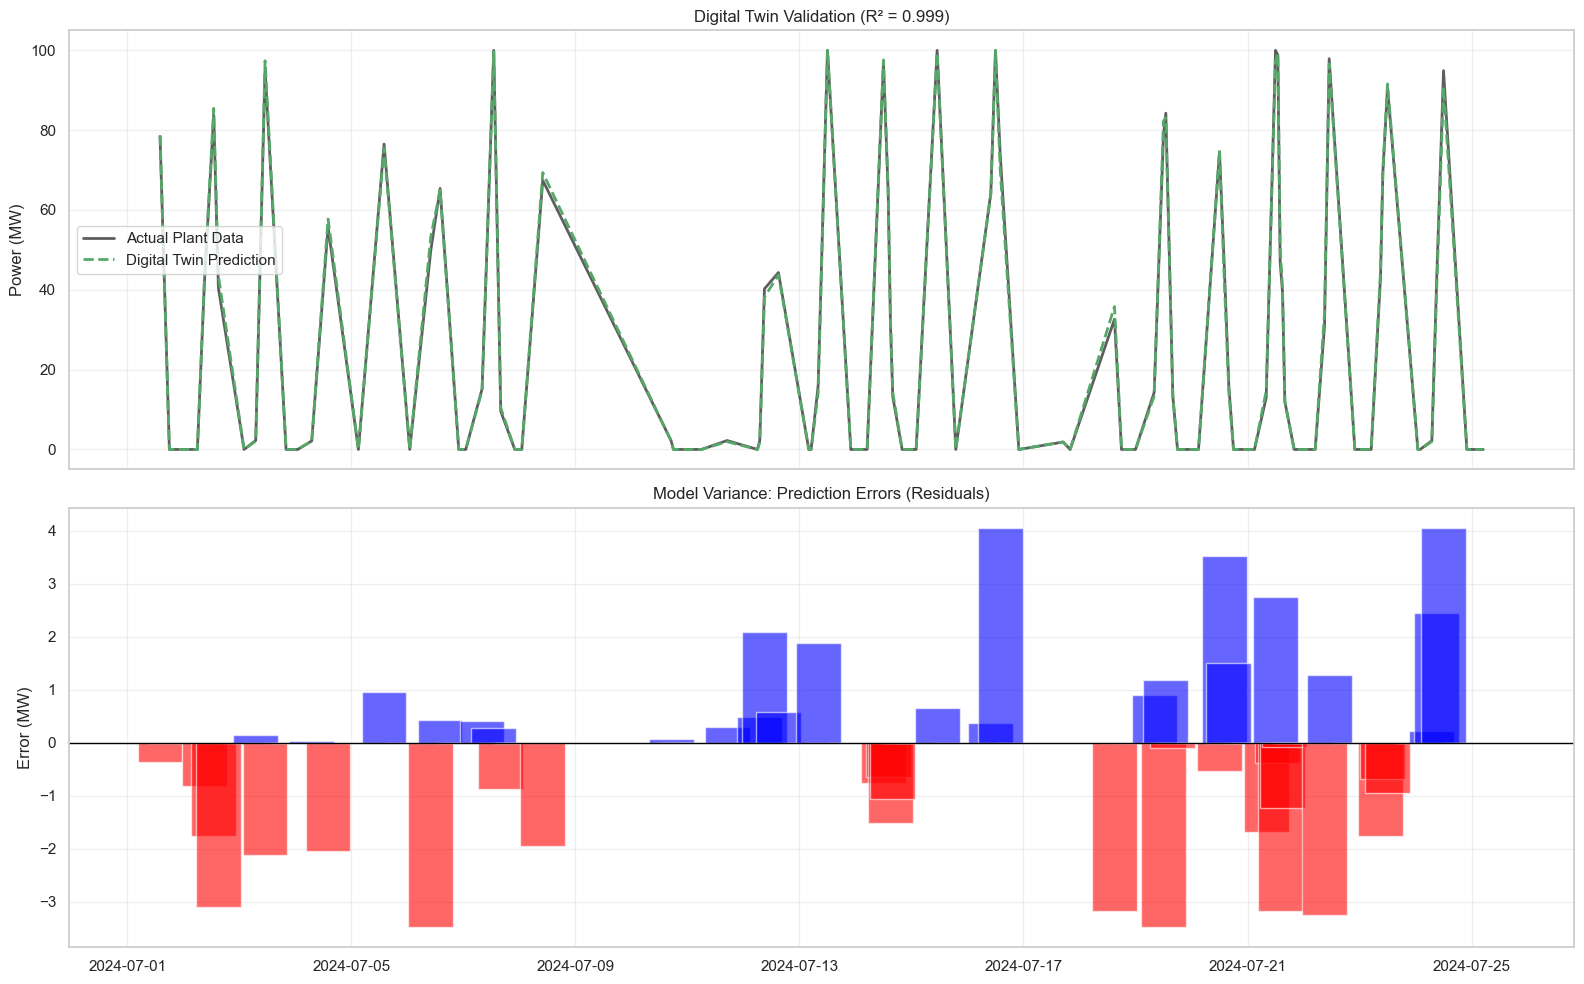

In [47]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison = comparison.sort_index()
comparison['Residuals'] = comparison['Actual'] - comparison['Predicted']

# 100 hr slice
mid = len(comparison) // 2
subset = comparison.iloc[mid : mid + 100]

fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Actual vs Predicted
ax[0].plot(subset.index, subset['Actual'], 'k-', label='Actual Plant Data', linewidth=2, alpha=0.7)
ax[0].plot(subset.index, subset['Predicted'], 'g--', label='Digital Twin Prediction', linewidth=2)
ax[0].set_title(f"Digital Twin Validation (R² = {r2:.3f})")
ax[0].set_ylabel("Power (MW)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Variance
colors = ['red' if x < 0 else 'blue' for x in subset['Residuals']]
ax[1].bar(subset.index, subset['Residuals'], color=colors, alpha=0.6)
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_title("Model Variance: Prediction Errors (Residuals)")
ax[1].set_ylabel("Error (MW)")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:
def generate_10_year_forecast(base_annual_mwh, degradation=0.005):
    results = []
    
    for year in range(1, 11):
        # Apply Degradation Factor (0.5% per year)
        deg_factor = (1 - degradation) ** (year - 1)
        
        # Calculate Scenarios
        p50 = base_annual_mwh * deg_factor
        p70 = p50 * 0.95  # Standard financial proxy
        p90 = p50 * 0.90  # Standard bankability proxy
        
        results.append({
            "Year": year,
            "Degradation": f"{(1-deg_factor)*100:.2f}%",
            "P50 Generation (MWh)": round(p50, 2),
            "P70 Generation (MWh)": round(p70, 2),
            "P90 Generation (MWh)": round(p90, 2)
        })
        
    return pd.DataFrame(results)

# Calculate based on the Year 1 "Actual" total
base_gen = df['Active_Power_MW'].sum()
forecast_df = generate_10_year_forecast(base_gen)

# Display Table
forecast_df.style.background_gradient(cmap='Greens', subset=['P50 Generation (MWh)'])

,Year,Degradation,P50 Generation (MWh),P70 Generation (MWh),P90 Generation (MWh)
0,1,0.00%,173108.470000,164453.050000,155797.620000
1,2,0.50%,172242.930000,163630.780000,155018.640000
2,3,1.00%,171381.710000,162812.630000,154243.540000
3,4,1.49%,170524.810000,161998.570000,153472.330000
4,5,1.99%,169672.180000,161188.570000,152704.960000
5,6,2.48%,168823.820000,160382.630000,151941.440000
6,7,2.96%,167979.700000,159580.720000,151181.730000
7,8,3.45%,167139.800000,158782.810000,150425.820000
8,9,3.93%,166304.100000,157988.900000,149673.690000
9,10,4.41%,165472.580000,157198.950000,148925.330000
